In [ ]:
## EEG signal classification into wake and drowsy using CNN network


## POSSIBLE PROBLEMS & SOLUTIONS:
# 1. overfitting (see the plots - how bad ?) 
# no. of training examples: 83076 (train set) = Train on 74768 samples, validate on 8308 samples
# no. of trainable parameters: 4,793,957
# => reduce the no. of epochs
#    upsample data, 
#    reduce parameters/ change network, 
#    use dropout (in last-but-one layer)
##   WHERE IS THE LEARNING RATE BEING SPECIFIED ?

# 2. issue with parameter values: softmax vs sigmoid,  dense = 1 or 2,  binary or categorical cross-entropy

# 3. conversion of CNN output (float) to category (0,1) - why not done by the model?


## how to do train test split keeping class distribution similar
## use stratified_sampling (keep class ratios similar in train test sets) instead of random sampling
# https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification
## class_weight = balanced (giving more weightage to penalties for the smaller class)
# https://stackoverflow.com/questions/30972029/how-does-the-class-weight-parameter-in-scikit-learn-work



##  INFERENCE: recall is low (0.65) for sleep state (class 1)  ##
'''
(array([0.92174321, 0.89073806]),
 array([0.98116972, 0.64823591]),
 array([0.95052854, 0.75038098]),
 array([8019, 1899]))
'''

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from scipy import stats
import itertools
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split


import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


/home/intern_eyecare/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/intern_eyecare/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/intern_eyecare/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/intern_eyecare/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/intern_eyecare/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it wi

In [2]:
file_location=r'/home/intern_eyecare/Desktop/EEG/raw_data' #C:\Users\BOL1KOR\Desktop\BCI Project\Pickle_Files\Pickle_files_eeg'
os.chdir(r'/home/intern_eyecare/Desktop/EEG/raw_data') #C:\Users\BOL1KOR\Desktop\BCI Project\Pickle_Files\Pickle_files_eeg')


In [3]:
dfull = pickle.load(open('raw_EEG_all_patients.pkl', 'rb'))  #raw_EEG_all_patients.pkl

In [4]:
dfull.head(3)

,0,1,2,3,4,5,6,7,8,9,...,2994,2995,2996,2997,2998,2999,pID,day,epoch,class_label
0,9.041758,-6.624176,2.756044,-1.305495,15.134066,-11.942857,-5.850549,3.626374,-3.819780,-24.320879,...,9.041758,2.369231,1.885714,9.041758,7.301099,16.294505,404,2,s1e1,wake
1,9.428571,13.296703,11.169231,14.167033,6.334066,10.589011,6.817582,10.202198,12.716484,7.107692,...,-28.382418,-14.747253,-23.547253,-23.257143,-13.683516,-7.494505,404,2,s1e2,wake
2,-0.048352,-7.687912,-14.360440,-17.745055,-21.903297,-16.874725,-16.874725,-12.523077,-12.909890,-15.520879,...,1.305495,3.723077,-6.720879,-4.303297,-6.527473,-4.109890,404,2,s1e3,wake


In [5]:
### Convert from 3-class to 2-class ####
dfull['class2'] = dfull['class_label']
dfull['class2'] = [0 if x == 'wake' else 1 for x in dfull['class2']]

In [6]:
## convert selected columns to categories 
## DO NOT CONVERT 'class2' from numeric to category - this probably gives error in grid search
dfull[['class_label']] = dfull[['class_label']].astype('str')        # ,'class2'
#dfull[['class_label']] = dfull[['class_label']].astype('category')   # ,'class2'

In [7]:
dfull.groupby('class_label').size()

class_label
sleep_stage_1     2804
sleep_stage_2    17799
wake             72391
dtype: int64

In [8]:
dfull.isnull().sum()

0                 0
1                 0
2                 0
3                 0
4                 0
5                 0
6                 0
7                 0
8                 0
9                 0
10                0
11                0
12                0
13                0
14                0
15                0
16                0
17                0
18                0
19                0
20                0
21                0
22                0
23                0
24                0
25                0
26                0
27                0
28                0
29                0
               ... 
2975              0
2976              0
2977              0
2978              0
2979              0
2980              0
2981              0
2982              0
2983              0
2984              0
2985              0
2986              0
2987              0
2988              0
2989              0
2990              0
2991              0
2992              0
2993              0


In [9]:
## drop column '2999' with NAN values instead of dropping the rows (which will reduce data)
dfull = dfull.drop([2999],1)
dfull.head(1)

,0,1,2,3,4,5,6,7,8,9,...,2994,2995,2996,2997,2998,pID,day,epoch,class_label,class2
0,9.041758,-6.624176,2.756044,-1.305495,15.134066,-11.942857,-5.850549,3.626374,-3.81978,-24.320879,...,9.041758,2.369231,1.885714,9.041758,7.301099,404,2,s1e1,wake,0


In [10]:
### all patient data ##
#ID = dfull['pID']
#ID = pd.DataFrame(dfull['pID'].unique())
ID = dfull['pID'].unique()
ID.dtype

dtype('O')

In [ ]:
'''def getData(IDs, df):
    dataset = pd.DataFrame(columns = df.columns)
    count = 0
    for i in range(len(IDs)):
        for j in range(len(df)):
            if IDs[i] == df.loc[j,'pID']:
                dataset.loc[count] = df.loc[j]
                count += 1
        print(i)
    return dataset'''

In [11]:
#### segregate data into train:test set by pat id, then balance the data
#Test = dfull[ (dfull.pID == '402') & (dfull.day == '2') ]
#Train = dfull[~( (dfull.pID == '402') & (dfull.day == '2') )]

np.random.seed(456)
msk = np.random.rand(len(ID)) < 0.8

trainIDs = pd.DataFrame()
testIDs = pd.DataFrame()
trainIDs['pID'] = ID[msk]
testIDs['pID'] = ID[~msk]

In [12]:
trainIDs

,pID
0,404
1,400
2,410
3,407
4,402
5,414
6,419
7,405
8,417
9,413


In [13]:
testIDs

,pID
0,406
1,411


In [14]:
#trainIDs.reset_index(inplace=True)
#testIDs.reset_index(inplace=True)

Train = dfull.loc[dfull['pID'].isin(ID[msk])] #pd.DataFrame(getData(trainIDs['pID'],dfull), columns = dfull.columns)
Test = dfull.loc[dfull['pID'].isin(ID[~msk])] #pd.DataFrame(getData(testIDs['pID'],dfull), columns = dfull.columns)

In [15]:
Test.head(1)

,0,1,2,3,4,5,6,7,8,9,...,2994,2995,2996,2997,2998,pID,day,epoch,class_label,class2
7362,7.809524,10.571429,17.142857,17.714286,19.142857,22.761905,13.904762,25.333333,28.190476,26.857143,...,-2.190476,-0.190476,-6.380952,2.190476,8.380952,406,1,s1e1,wake,0


In [16]:
print(Train.shape)
print(Test.shape)

## also, check the distribution of class 0 & 1 in the train & test sets
'''
print('Train distribution')
print(Train.groupby('class2').size())
print('')
print('Test distribution')
print(Test.groupby('class2').size())'''

(83076, 3004)
(9918, 3004)


In [17]:
X_train = Train.drop(['pID','day','epoch','class_label','class2'], 1).reset_index()
X_test = Test.drop(['pID','day','epoch','class_label','class2'], 1).reset_index()
y_train = Train['class2'].reset_index()
y_test = Test['class2'].reset_index()

X_train = X_train.drop(['index'], 1)
X_test = X_test.drop(['index'],1)
y_train = y_train.drop(['index'],1)
y_test = y_test.drop(['index'],1)

print(X_train.head(1))
#print(X_test.head(1))
print('')
print(y_train.head(1))
#print(y_test.head(1))

       0         1         2         3          4          5         6     \
0  9.041758 -6.624176  2.756044 -1.305495  15.134066 -11.942857 -5.850549   

       7        8          9       ...         2989      2990  2991      2992  \
0  3.626374 -3.81978 -24.320879    ...     40.18022  40.47033  39.6  57.49011   

       2993      2994      2995      2996      2997      2998  
0 -0.048352  9.041758  2.369231  1.885714  9.041758  7.301099  

[1 rows x 2999 columns]

   class2
0       0


In [18]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# http://benalexkeen.com/feature-scaling-with-scikit-learn/
# standardscaler: suitable for normally distributed data
# minMaxScaler: (x-min)/(max - min)

## normalize the data  : can also use other scalers like StandardScaler()
scaler = StandardScaler()  #MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#X_train_scaled.shape

In [19]:
## re-shaping tha data for input to conv net
# https://stackoverflow.com/questions/43235531/convolutional-neural-network-conv1d-input-shape
nrows, ncols = X_train_scaled.shape
X_train_array =  X_train_scaled.reshape(nrows, ncols, 1)
print(X_train_array)

[[[ 0.3289354 ]
  [-0.24972034]
  [ 0.10286261]
  ...
  [ 0.0371708 ]
  [ 0.31496167]
  [ 0.25228504]]

 [[ 0.3433974 ]
  [ 0.49274115]
  [ 0.41634497]
  ...
  [-0.91905181]
  [-0.89965353]
  [-0.53575978]]

 [[-0.01092165]
  [-0.28936634]
  [-0.53491185]
  ...
  [-0.28641784]
  [-0.18688533]
  [-0.2670256 ]]

 ...

 [[-0.74797249]
  [-0.71309437]
  [-0.45040846]
  ...
  [-0.01441021]
  [-0.04551816]
  [-0.18468311]]

 [[-0.13492602]
  [-0.09211019]
  [ 0.01602985]
  ...
  [ 0.48276164]
  [ 0.53131937]
  [ 0.11657905]]

 [[-0.715013  ]
  [-0.76895009]
  [-1.07780085]
  ...
  [ 0.30709426]
  [ 0.31251893]
  [-0.2972426 ]]]


In [ ]:
#### model building ####

In [ ]:
'''
# GOOGLE: 
# neural network in python ; 
# mlp classifier (multilayer perceptron)
# https://www.kdnuggets.com/2016/10/beginners-guide-neural-networks-python-scikit-learn.html/2
# https://scikit-learn.org/stable/modules/neural_networks_supervised.html

## Neural Network Classifier (by Sowmya) ##
from sklearn.neural_network import MLPClassifier
model_mlp = MLPClassifier(hidden_layer_sizes = 8, activation = 'logistic', solver = 'sgd', learning_rate = 'adaptive', random_state = 45, max_iter = 500, learning_rate_init = 1, momentum = 0.9)
model_mlp.fit(X_train_scaled,y_train)



# following are examples of fully connected networks
## GOOGLE: sample deep neural network for classification
# https://medium.com/@pushkarmandot/build-your-first-deep-learning-neural-network-model-using-keras-in-python-a90b5864116d
# https://gogul09.github.io/software/first-neural-network-keras
# https://www.bogotobogo.com/python/scikit-learn/Artificial-Neural-Network-ANN-10-Deep-Learning-3-Theano-TensorFlow-Keras.php
# https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/


# sample convolutional neural network for classification 1d data
# https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/
# https://www.quora.com/When-is-a-1D-Convolutional-Neural-Network-appropriate-to-use

'''
# https://stackoverflow.com/questions/43076609/how-to-calculate-precision-and-recall-in-keras
# https://github.com/GeekLiB/keras/blob/master/keras/metrics.py
# https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
# https://keras.io/metrics/

In [20]:
from datetime import datetime
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2019-01-10 11:12:01'

In [21]:
# define model: 1 conv layer, 1 fully-connected layer, 1 output layer
model = Sequential()  ## to initialize NN

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(ncols, 1))) 
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(50, activation='relu'))

model.add(Dense(1, activation='sigmoid'))  # this is the output layer for binary classification
print(model.summary())

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2997, 64)          256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1498, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 95872)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                4793650   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 4,793,957
Trainable params: 4,793,957
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
history = model.fit(X_train_array, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1)

## steps to plot train & validation accuracy & loss
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
#history = model.fit(x_test, y_test, nb_epoch=10, validation_split=0.2, shuffle=True)

Train on 74768 samples, validate on 8308 samples
Epoch 1/100
74768/74768 [==============================] - 52s 702us/step - loss: 0.2614 - acc: 0.9174 - val_loss: 0.1809 - val_acc: 0.9650
Epoch 2/100
74768/74768 [==============================] - 51s 688us/step - loss: 0.1760 - acc: 0.9530 - val_loss: 0.1398 - val_acc: 0.9717
Epoch 3/100
74768/74768 [==============================] - 50s 667us/step - loss: 0.1289 - acc: 0.9614 - val_loss: 0.1449 - val_acc: 0.9705
Epoch 4/100
74768/74768 [==============================] - 49s 661us/step - loss: 0.1055 - acc: 0.9668 - val_loss: 0.2104 - val_acc: 0.9547
Epoch 5/100
74768/74768 [==============================] - 49s 662us/step - loss: 0.0908 - acc: 0.9700 - val_loss: 0.1514 - val_acc: 0.9700
Epoch 6/100
74768/74768 [==============================] - 50s 662us/step - loss: 0.0797 - acc: 0.9737 - val_loss: 0.1420 - val_acc: 0.9663
Epoch 7/100
74768/74768 [==============================] - 49s 659us/step - loss: 0.0718 - acc: 0.9761 - val_lo

Epoch 59/100
74768/74768 [==============================] - 49s 657us/step - loss: 0.0148 - acc: 0.9970 - val_loss: 0.3534 - val_acc: 0.9579
Epoch 60/100
74768/74768 [==============================] - 49s 659us/step - loss: 0.0101 - acc: 0.9984 - val_loss: 0.4639 - val_acc: 0.9395
Epoch 61/100
74768/74768 [==============================] - 49s 657us/step - loss: 0.0090 - acc: 0.9988 - val_loss: 0.4257 - val_acc: 0.9487
Epoch 62/100
74768/74768 [==============================] - 49s 659us/step - loss: 0.0099 - acc: 0.9984 - val_loss: 0.3489 - val_acc: 0.9551
Epoch 63/100
74768/74768 [==============================] - 49s 661us/step - loss: 0.0119 - acc: 0.9980 - val_loss: 0.3453 - val_acc: 0.9567
Epoch 64/100
74768/74768 [==============================] - 49s 655us/step - loss: 0.0115 - acc: 0.9981 - val_loss: 0.3583 - val_acc: 0.9567
Epoch 65/100
74768/74768 [==============================] - 49s 657us/step - loss: 0.0087 - acc: 0.9988 - val_loss: 0.3573 - val_acc: 0.9559
Epoch 66/100


In [23]:
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2019-01-10 12:34:28'

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


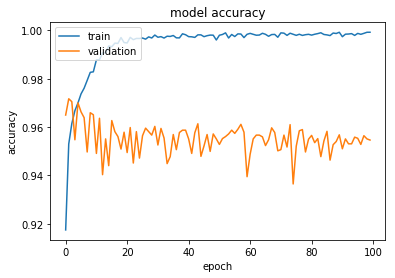

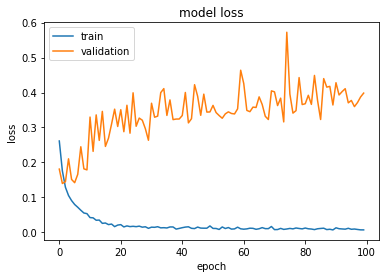

In [24]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [44]:
#import pickle
#pickle.dump(model, open('/home/intern_eyecare/Desktop/EEG/cnn_model.pkl','wb'))
model.save('/home/intern_eyecare/Desktop/EEG/cnn_model.pkl')

In [25]:
## predict on test data - check metrics
#y_pred = model_svc.predict(X_test_scaled)

nrows2, ncols2 = X_test_scaled.shape
X_test_array =  X_test_scaled.reshape(nrows2, ncols2, 1)
y_pred = model.predict(X_test_array)

In [26]:
print(y_test.head(2))
print('')
print(y_test.tail(3))

   class2
0       0
1       0

      class2
9915       1
9916       1
9917       1


In [27]:
y_test.dtypes()

TypeError: 'Series' object is not callable

In [28]:
y_pred

array([[3.3649221e-24],
       [3.8442626e-35],
       [0.0000000e+00],
       ...,
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00]], dtype=float32)

In [29]:
# convert array to dataframe

y_pred2 = pd.DataFrame(y_pred)
print(y_pred2.head(2))
print('')
print(y_pred2.tail(2))

              0
0  3.364922e-24
1  3.844263e-35

        0
9916  0.0
9917  0.0


In [30]:
y_pred3 = round(y_pred2)
y_pred3
print(y_pred3.head(2))
print('')
print(y_pred3.tail(2))

     0
0  0.0
1  0.0

        0
9916  0.0
9917  0.0


In [33]:
y_pred3[0].unique()

array([0., 1.])

In [34]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [35]:
## Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

class_names = [0,1] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'

print(confusion_matrix(y_test, y_pred3))

[[7868  151]
 [ 668 1231]]


In [46]:
## join the test set predictions & actual values into a dataframe
res = y_pred3
res.columns = ['pred']
res.head(2)

,pred
0,0.0
1,0.0


In [47]:
res = pd.concat([res,y_test], axis=1)
res.head(2)

,pred,class2
0,0.0,0
1,0.0,0


In [48]:
#print(classification_report(y_test, y_pred3, target_names=class_names))
print(classification_report(res['class2'], res['pred'], target_names=class_names))

TypeError: object of type 'int' has no len()

In [38]:
precision_recall_fscore_support(y_test,y_pred3)

# layout of results
# precision: class 0, class 1   ==> [0: wake; 1: sleep/drowsy/fatigue]
# recall: class 0, class 1
# f1 score: class 0, class 1
# support: class 0, class 1

## INFERENCE: recall is low for sleep state

(array([0.92174321, 0.89073806]),
 array([0.98116972, 0.64823591]),
 array([0.95052854, 0.75038098]),
 array([8019, 1899]))